# Notebook that uses real data as source for gravitational lens quad

In [1]:
# some python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from astropy.io import fits
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF


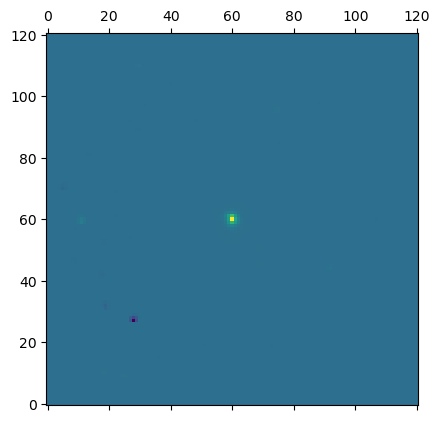

In [2]:
# read in the galaxy image for PG 0052+ 251
hdu = fits.open('data/pg52.fits')
data = hdu[0].data

# plot the image
plt.matshow(data, origin='lower')
plt.show()

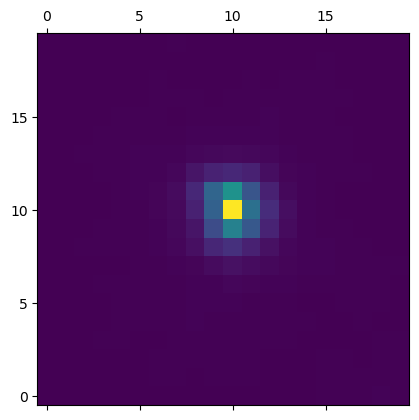

In [5]:
# create a cutout of the data
# we will use this cutout to simulate the lensing system
data_cutout = data[50:70, 50:70]
plt.matshow(data_cutout, origin='lower')
plt.show()


### Q: create a square cutout of the data around the center and plot it, use this cutout as your source for the lensing
### Hint: check how big your image and where the center is


In [ ]:
# lens position
# change these values to see how the lensed image changes
ra_lens, dec_lens = 0, 0
# mass multiplier 
mass_multiplier = 1


# quasar point source position in the source plane 
# change these values to see how the lensed image changes
ra_source, dec_source = 0, 0

# brightness of the source
source_brightness = 100

In [ ]:

# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['EPL', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1. * mass_multiplier, 'gamma': 1.96, 'center_x': ra_lens, 'center_y': dec_lens, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 10, 'R_sersic': 1., 'n_sersic': 2, 'center_x': ra_lens, 'center_y': dec_lens}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'INTERPOL': interpolated model from an image
source_model_list = ['INTERPOL']
### MUST CREATE A DATA CUTOUT! ###
kwargs_interpol = {'image': data_cutout, 'amp': 1* source_brightness, 'center_x': ra_source, 'center_y': dec_source, 'scale': 0.1}

kwargs_source = [kwargs_interpol]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps = None)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

plt.matshow(np.log10(image_sim), origin='lower')
plt.show()

### Q: try lensing one of the other files!